<a href="https://colab.research.google.com/github/alishahmad/cove/blob/master/%5BSTUDENT%5DModule_1_Vehicle_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import geopandas as gpd

## Data Ingestion

In [24]:
vehicle_df = pd.read_csv("/content/car details v4.csv")

In [ ]:
vehicle_df.head(5)

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


## Split Data to Train and Test Set

In [62]:
from sklearn.model_selection import train_test_split

# Assuming 'vehicle_df' is your DataFrame and you want to stratify based on 'fuel' column
# Replace 'fuel' with your desired non-numerical column for stratification

# Get value counts for the stratify columns
stratify_counts = vehicle_df.groupby(['Make', 'Location']).size()

# Filter out combinations with less than 2 samples
valid_stratify_indices = stratify_counts[stratify_counts >= 2].index

# Filter the DataFrame to include only valid combinations
filtered_df = vehicle_df[vehicle_df.set_index(['Make', 'Location']).index.isin(valid_stratify_indices)]

# Perform train-test split on the filtered DataFrame

#X_train, X_test = train_test_split(filtered_df, test_size=0.3, stratify=filtered_df[['make', 'location']], random_state=42)

X_train, X_test = train_test_split(filtered_df, test_size=0.3, stratify=filtered_df[['Make', 'Location']], random_state=42)



## Data Exploration

### Price Distribution

In [63]:
X_train['Price'].describe()

,Price
count,1.261000e+03
mean,1.641044e+06
std,2.042766e+06
min,7.100100e+04
25%,4.950000e+05
50%,8.250000e+05
75%,1.950000e+06
max,2.750000e+07


<ipython-input-64-33add01cbe47>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['Price'])


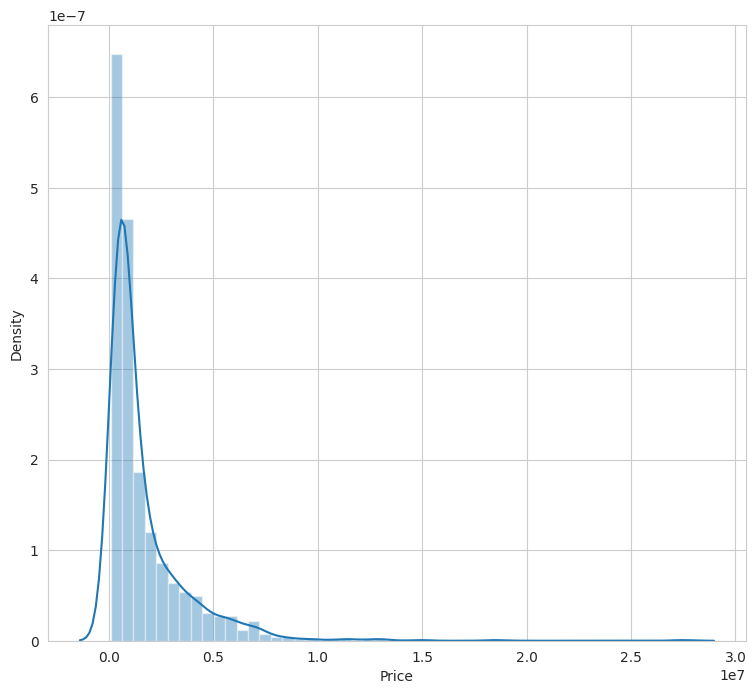

In [64]:
plt.figure(figsize=(9, 8))
sns.distplot(X_train['Price'])
plt.savefig('price.png')

<ipython-input-65-1fc72038dcfe>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(X_train['Price']))


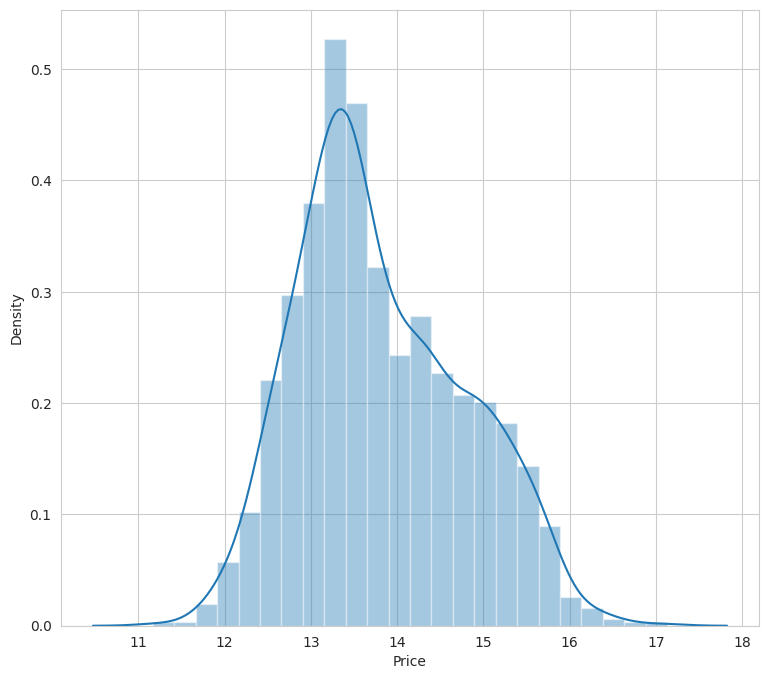

In [65]:
plt.figure(figsize=(9, 8))
sns.distplot(np.log(X_train['Price']))
plt.savefig('price_normal.png')

In [66]:
X_train['LogPrice'] = np.log(X_train['Price'])
X_train.drop(['Price'], inplace=True, axis=1)

### Inspecting other numerical columns

In [67]:
num_cols = X_train.select_dtypes(include=np.number).columns

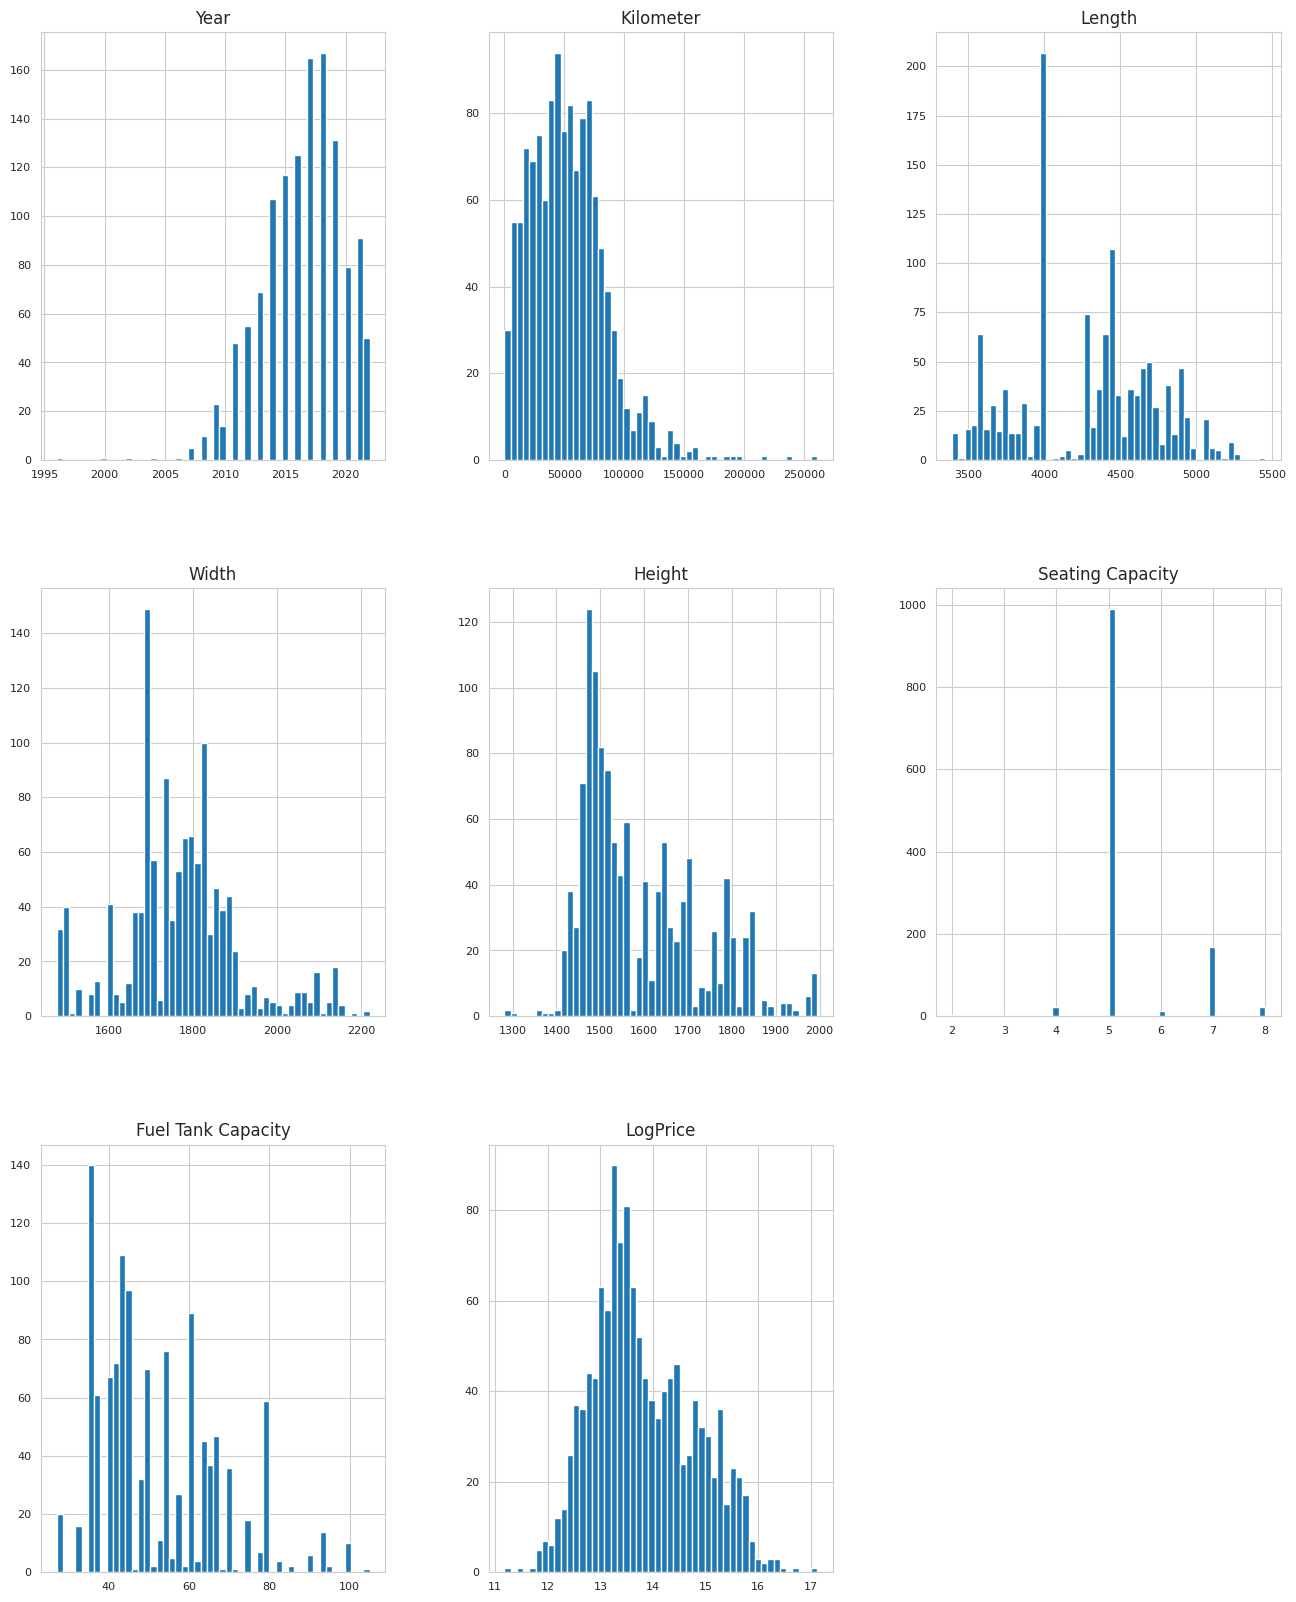

In [68]:
X_train[num_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
plt.savefig('histplot.png')

All other numerical features are more or less evenly distributed except for the 'Kilometer' variable where the features are concentrated towards a lower value. So let's inspect and correct thi

In [69]:
X_train['Kilometer'].describe()

,Kilometer
count,1261.000000
mean,52614.695480
std,32143.309084
min,1.000000
25%,28732.000000
50%,49500.000000
75%,71000.000000
max,261236.000000


We can see that the maximum value is way outside the upper 75-percentile of the distribution indicating that there are many outliers

### Correlation Analysis

In [70]:
num_corr = X_train[num_cols].corr()['LogPrice']

In [71]:
golden_features_list = num_corr[abs(num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 strongly correlated values with SalePrice:
LogPrice              1.000000
Width                 0.786092
Length                0.783949
Fuel Tank Capacity    0.742962
Year                  0.526685
Name: LogPrice, dtype: float64


View only features that have high correlation with high correlation (p>0.5)

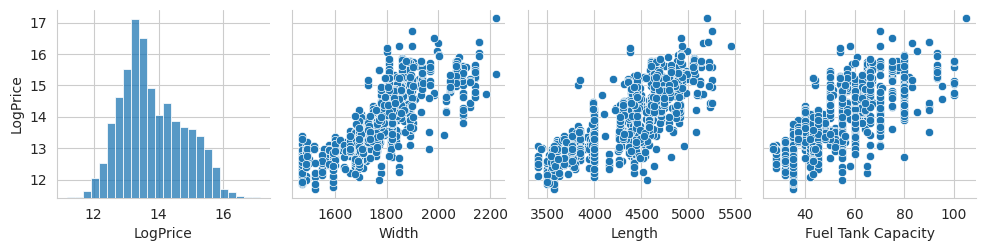

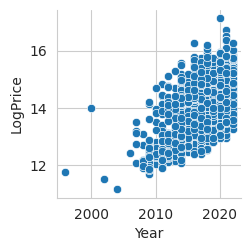

In [72]:
for i in range(0, len(X_train[golden_features_list.index].columns), 4):
    sns.pairplot(data=X_train[golden_features_list.index],
                x_vars=X_train[golden_features_list.index].columns[i:i+4],
                y_vars=['LogPrice']
                     )
    plt.savefig('corr_scatter_'+str(i)+'.png')

In [73]:
corr = X_train[num_cols].corr()

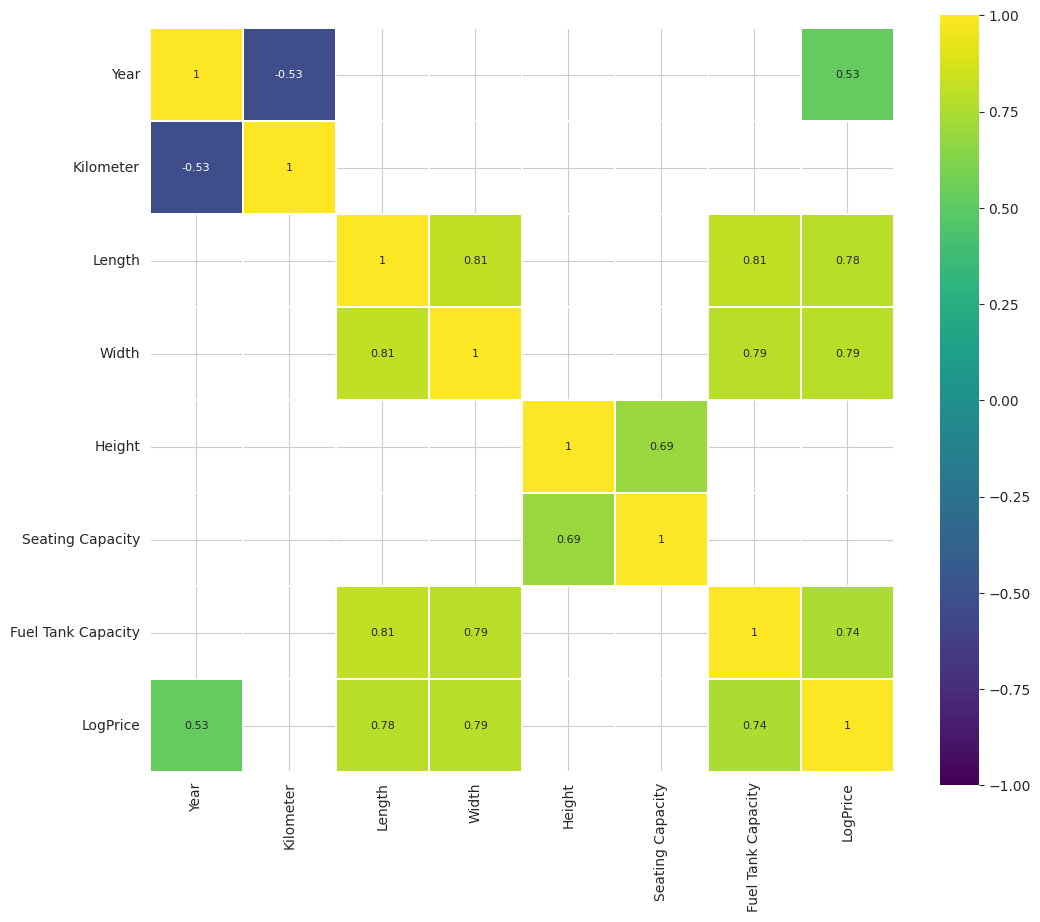

In [74]:
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

plt.savefig('corr.png')

### Ordinal Feature Analysis

In [75]:
ordinal_features = ['Age', 'Seating Capacity']

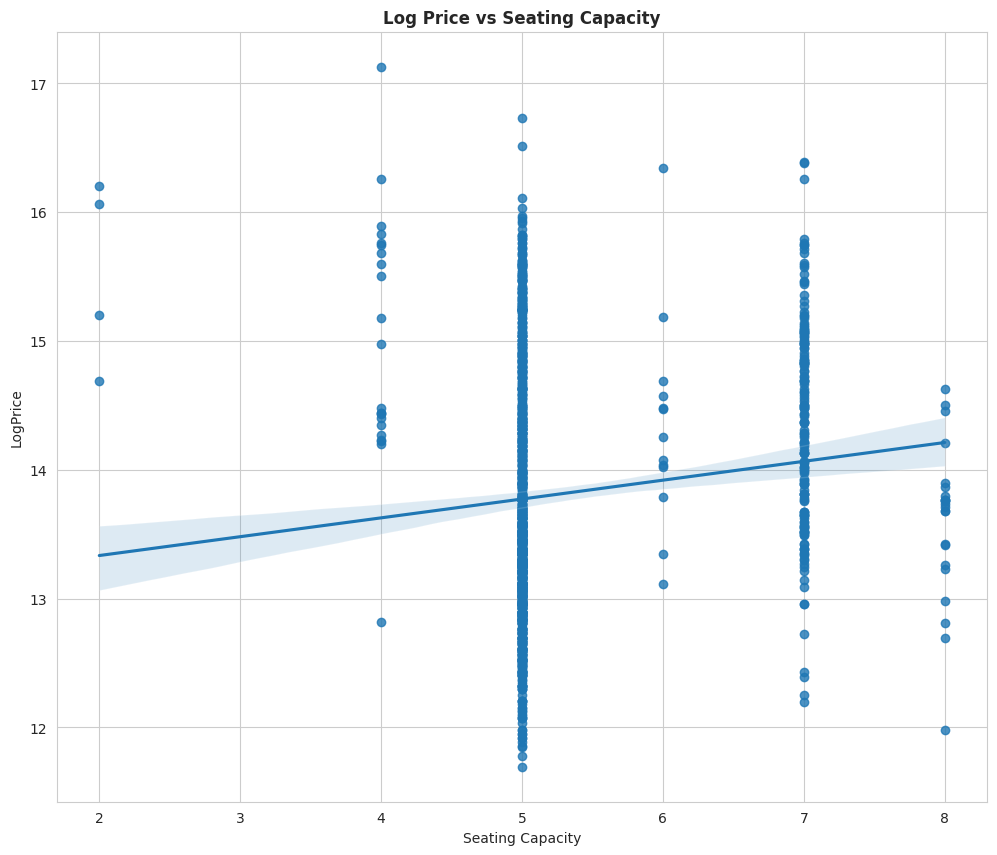

In [76]:
plt.figure(figsize=(12, 10))
sns.regplot(x='Seating Capacity',y='LogPrice', data=X_train)
plt.title('Log Price vs Seating Capacity', weight='bold')
plt.savefig('seating_capacity.png')

### Categorical Feature Analysis

In [77]:
cat_cols = X_train.select_dtypes(include=object).columns

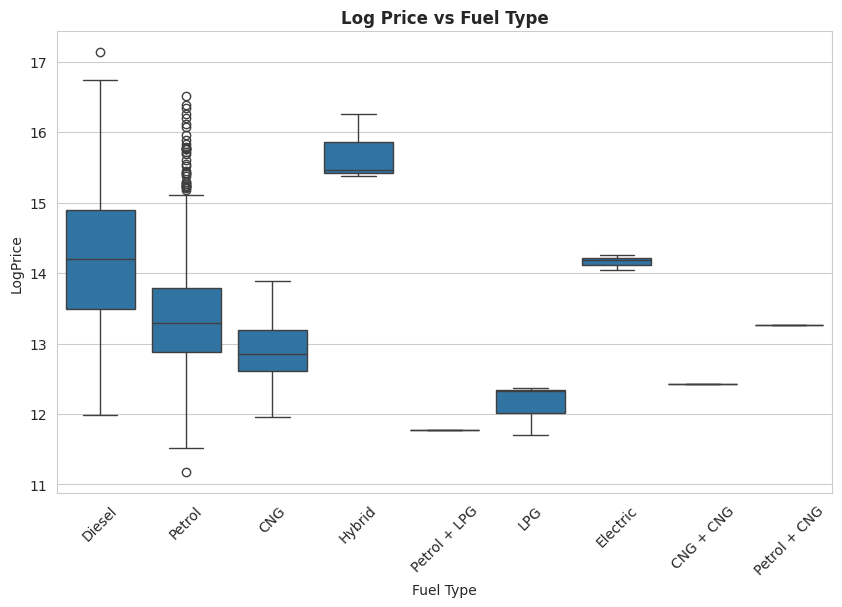

In [78]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Fuel Type', y='LogPrice', data=X_train)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.title('Log Price vs Fuel Type', weight='bold')
plt.savefig('fuel_type.png')

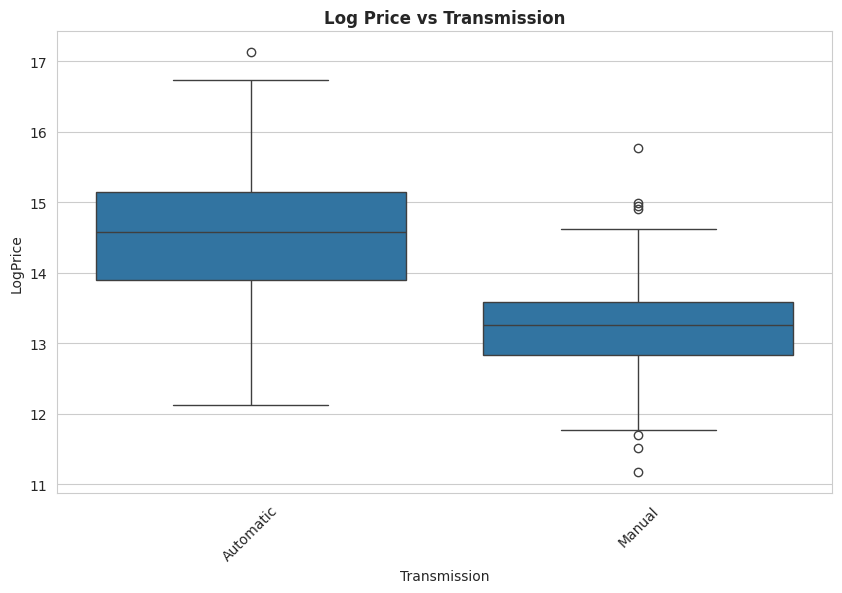

In [79]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Transmission', y='LogPrice', data=X_train)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.title('Log Price vs Transmission', weight='bold')
plt.savefig('transmission.png')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'White'),
  Text(1, 0, 'Black'),
  Text(2, 0, 'Red'),
  Text(3, 0, 'Brown'),
  Text(4, 0, 'Beige'),
  Text(5, 0, 'Silver'),
  Text(6, 0, 'Gold'),
  Text(7, 0, 'Blue'),
  Text(8, 0, 'Maroon'),
  Text(9, 0, 'Grey'),
  Text(10, 0, 'Yellow'),
  Text(11, 0, 'Others'),
  Text(12, 0, 'Bronze'),
  Text(13, 0, 'Orange'),
  Text(14, 0, 'Green'),
  Text(15, 0, 'Purple')])

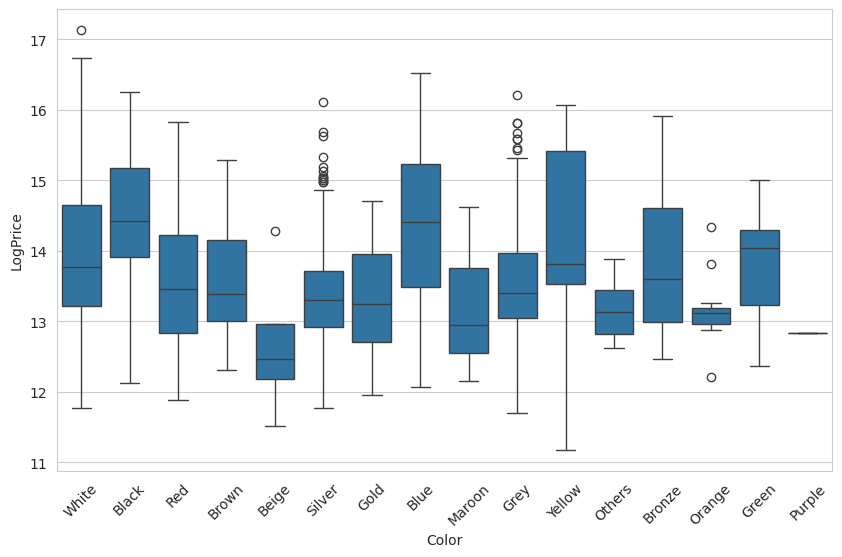

In [80]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Color', y='LogPrice', data=X_train)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Second'),
  Text(1, 0, 'First'),
  Text(2, 0, 'Third'),
  Text(3, 0, 'UnRegistered Car'),
  Text(4, 0, 'Fourth')])

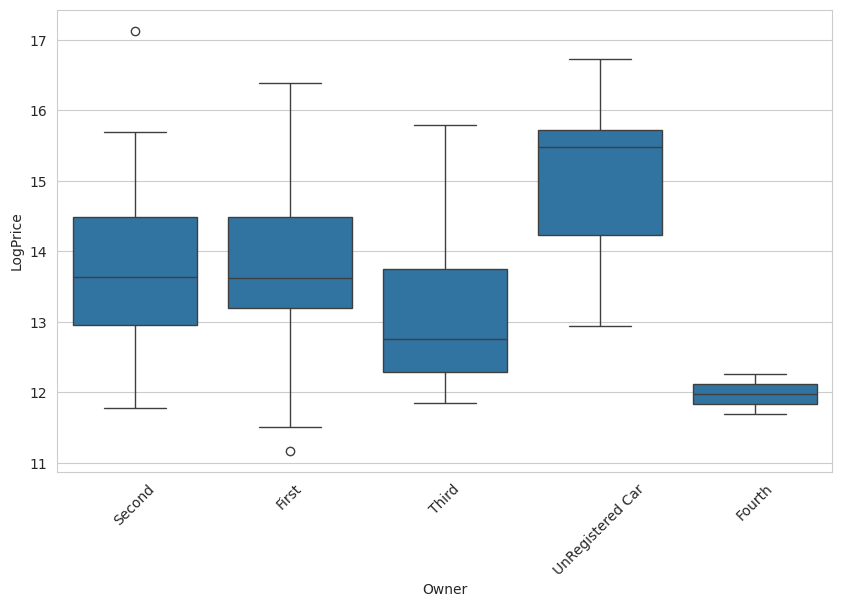

In [81]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Owner', y='LogPrice', data=X_train)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

([0, 1, 2],
 [Text(0, 0, 'Individual'),
  Text(1, 0, 'Corporate'),
  Text(2, 0, 'Commercial Registration')])

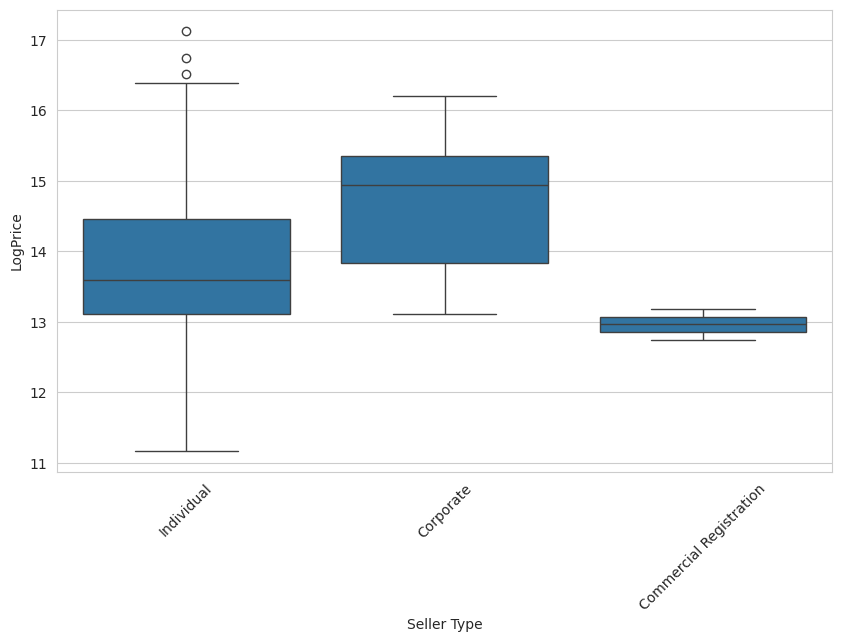

In [82]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Seller Type', y='LogPrice', data=X_train)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

## Feature Engineering

### Age Feature

In [56]:
#Engineer an Age Feature

#age =x_train['Year'].max() - X_train['Year']
age = X_train['Year'].max() - X_train['Year'] # Changed x_train to X_train


In [57]:
X_train.insert(3, column='Age', value=age)



In [58]:
X_train.drop(['Year'], axis=1, inplace=True)

### Car Volume Feature

In [59]:
#Engineer a Volume Feature



### Max Power Feature

In [83]:
#Extract max power feature

max_bhp = X_train['Max Power'].str.split(pat='@').str[0].str.split(pat=" ").str[0]
max_rpm =X_train['Max Power'].str.split(pat='@').str[1].str.split(pat=" ").str[1]
vehicle_max_power_df = pd.DataFrame({'Max_Power_BHP':max_bhp, 'Max_Power_RPM':max_rpm})

### Max Torque Feature

In [84]:
#Extract Torque Feature

max_bhp =X_train['Max Torque'].str.split(pat='@').str[0].str.split(pat=" ").str[0]
max_rpm =X_train['Max Torque'].str.split(pat='@').str[1].str.split(pat=" ").str[1]

vehicle_max_torque_df = pd.DataFrame({'Max_Torque_BHP':max_bhp, 'Max_Torque_RPM':max_rpm})

### CC Feature

In [85]:
#Extract CC Feature

cc =X_train['Engine'].str.split(pat=" ").str[0]
vehicle_cc_df = pd.DataFrame({'CC': cc})

In [86]:
X_train = pd.concat((X_train, vehicle_max_power_df, vehicle_max_torque_df, vehicle_cc_df), axis=1)
X_train.drop(['Max Power', 'Max Torque', 'Engine'], axis=1, inplace=True)

In [87]:
# Convert specified columns to int64, handling potential errors
for column in ['Max_Power_BHP', 'Max_Power_RPM', 'Max_Torque_BHP', 'Max_Torque_RPM', 'CC']:
  try:
    # Convert to numeric, coerce errors to NaN, fill NaN with 0, and then convert to Int64
    X_train[column] = pd.to_numeric(X_train[column], errors='coerce').fillna(0).astype(int)  # Changed to int instead of Int64
  except KeyError:
    print(f"Column '{column}' not found in DataFrame.")

### Verifying the Created Features

In [91]:
num_cols = X_train.select_dtypes(include=np.number).columns

In [92]:
plt.figure(figsize=(5, 4))
sns.regplot(x='Age',y='LogPrice', data=X_train)
plt.title('Log Price vs Car Age', weight='bold')
plt.savefig('age.png')

KeyError: 'Age'

<Figure size 500x400 with 0 Axes>

In [ ]:
plt.figure(figsize=(5, 4))
sns.regplot(x='Max_Torque_BHP',y='LogPrice', data=X_train)
plt.title('Log Price vs Max Torque', weight='bold')
plt.savefig('max_torque.png')

In [ ]:
plt.figure(figsize=(5, 4))
sns.regplot(x='Max_Torque_BHP',y='LogPrice', data=X_train)
plt.title('Log Price vs Max Power', weight='bold')
plt.savefig('max_power_price.png')

In [ ]:
plt.figure(figsize=(5, 4))
sns.regplot(x='CC',y='LogPrice', data=X_train)
plt.title('Log Price vs CC', weight='bold')
plt.savefig('cc_price.png')

In [ ]:
plt.figure(figsize=(5, 4))
sns.regplot(x='Volume',y='LogPrice', data=X_train)
plt.title('Volume vs CC', weight='bold')
plt.savefig('volume_price.png')

In [ ]:
num_corr = X_train[num_cols].corr()['LogPrice']
golden_features_list = num_corr[abs(num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

In [ ]:
for i in range(0, len(X_train[golden_features_list.index].columns), 4):
    sns.pairplot(data=X_train[golden_features_list.index],
                x_vars=X_train[golden_features_list.index].columns[i:i+4],
                y_vars=['LogPrice']
                     )

In [ ]:
corr = X_train[num_cols].corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

## Data Pre-processing

### Scaling Numerical Values

In [98]:
#Rescale the Numerical Features

X_train['Kilometer'] = X_train['Kilometer'] / 10000

X_train['Length'] =X_train['Length'] / 1000

X_train['Width'] =X_train['Width'] / 1000

X_train['Height'] =X_train['Height'] / 1000

X_train['Fuel Tank Capacity'] =X_train['Fuel Tank Capacity'] / 10

X_train['Max_Power_BHP'] =X_train['Max_Power_BHP'] / 100

X_train['Max_Power_RPM'] =X_train['Max_Power_RPM'] / 1000

X_train['Max_Torque_BHP'] =X_train['Max_Torque_BHP'] / 100

X_train['Max_Torque_RPM'] =X_train['Max_Torque_RPM'] / 1000

X_train['CC'] =X_train['CC'] / 1000

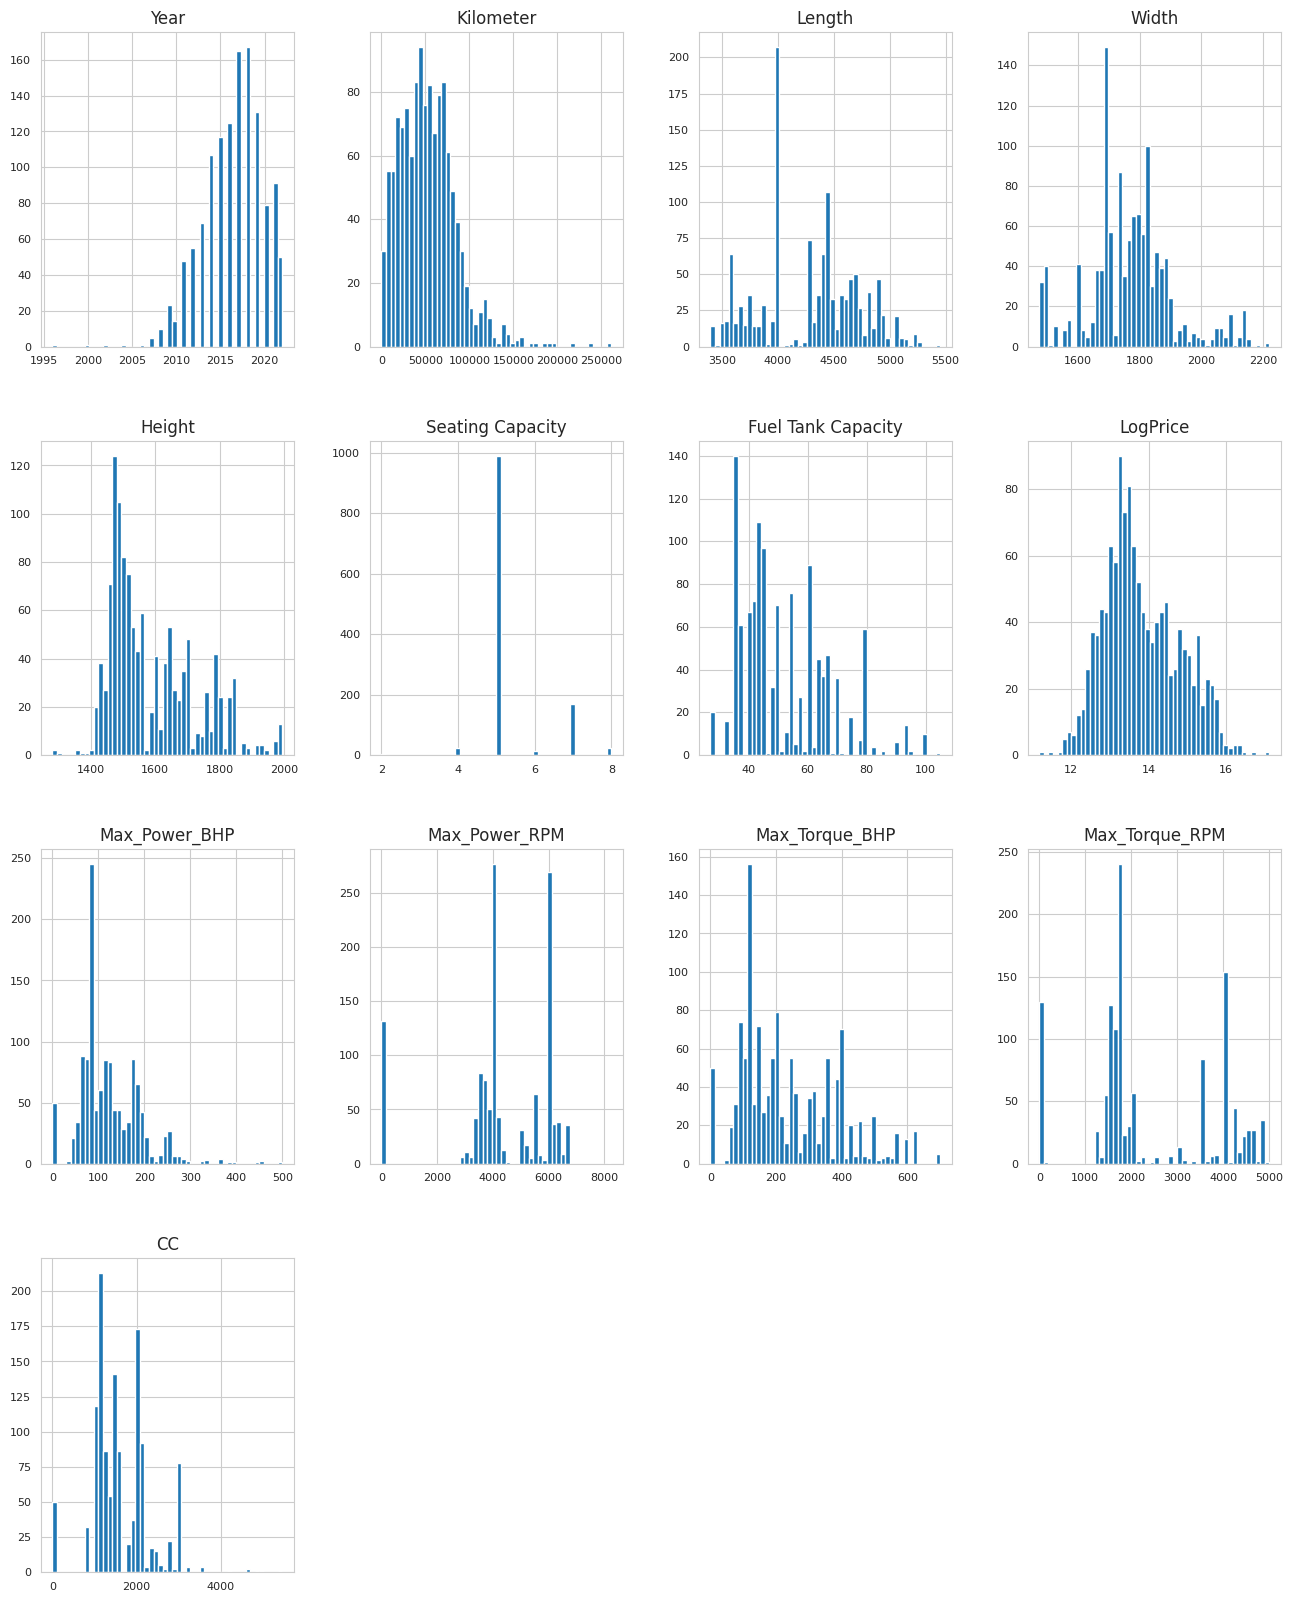

In [94]:
X_train[num_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Encoding Categorical Attributes

In [99]:
cat_cols = X_train.select_dtypes(include=object).columns

In [104]:
# Assuming X_train is your DataFrame and cat_cols contains the categorical columns
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the encoder on the categorical columns
encoder.fit_transform(X_train[cat_cols])

encoded_data = encoder.fit_transform(X_train[cat_cols])

# Create a new DataFrame with the encoded features
cat_encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the encoded DataFrame with the original DataFrame, dropping the original categorical columns
# X_train_encoded = pd.concat([X_train.drop(cat_cols, axis=1), encoded_df], axis=1)

# Now X_train_encoded contains your data with one-hot encoded categorical features.

In [105]:
X_train_encoded_df = pd.concat([X_train[num_cols].reset_index(drop=True), cat_encoded_df.reset_index(drop=True)], axis=1, ignore_index=True)

In [106]:
num_cols_list = X_train[num_cols].columns.to_list()
cat_cols_list = cat_encoded_df.columns.to_list()

# Combine the lists using the + operator
all_columns = num_cols_list + cat_cols_list

In [107]:
X_train_encoded_df.columns = all_columns

### Handling Missing Values

In [101]:
rows_with_missing_values = X_train.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {rows_with_missing_values}")

Number of rows with missing values: 111


In [102]:
from sklearn.impute import KNNImputer

In [108]:
# Use KNN Imputer to Fill in the Missing Values

X_train_encoded_no_na =

SyntaxError: invalid syntax (<ipython-input-108-6b2da29b481c>, line 3)

In [ ]:
X_train_encoded_no_na_df = pd.DataFrame(X_train_encoded_no_na, columns=all_columns)

In [ ]:
X_train_encoded_no_na_df.isnull().any(axis=1).sum()

## Train the Linear Regression Model

### Linear Regularization (not regularized)

Sure! A linear regression model is a way to predict a dependent variable (or target) based on one or more independent variables (or features). The basic idea is to find a linear relationship between the variables.

#### 1. Basic Concept

In its simplest form (simple linear regression), the model assumes that the relationship between the independent variable \( x \) and the dependent variable \( y \) can be expressed with the equation:

$\
y = \theta_0 + \theta_1 x + \epsilon
$

where:
- $\ y $ is the predicted value (dependent variable).
- $\theta_0 $ is the y-intercept (the value of $\ y $ when $\ x = 0 $).
- $\theta_1 $ is the slope of the line (how much $\ y $ changes for a one-unit change in $\ x $).
- \$\epsilon $ is the error term (the difference between the actual and predicted values).

#### 2. Multiple Linear Regression

When there are multiple independent variables, the model can be extended to:

$\
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n + \epsilon
$

Here:
- $\ x_1, x_2, \ldots, x_n $ are the independent variables.
- $\theta_0, \theta_1, \ldots, \theta_n $ are the coefficients for each variable.

#### 3. Objective

The goal of linear regression is to find the values of the coefficients $\theta $ that minimize the difference between the predicted values and the actual values. This is often done using the **least squares method**, which minimizes the sum of the squared differences (errors):

$\
J(\theta) = \frac{1}{2} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
$

where $\hat{y} = X\theta $ (the predicted values).

#### 4. Matrix Formulation

In matrix terms, we can express the model as:

$\
y = X\theta + \epsilon
$

where:
- $\ y $ is the vector of observed values.
- $\ X $ is the matrix of input features (including a column of ones for the intercept).
- $\theta $ is the vector of coefficients.

#### 5. Finding the Coefficients

To find the coefficients $\theta $, we use the closed-form solution:

$\
\theta = (X^T X)^{-1} X^T y
$

#### 6. Interpretation

- **Intercept $\theta_0 $**: This is where the regression line crosses the y-axis.
- **Slope $\theta_i $**: This tells us how much $\ y $ changes for a one-unit increase in $\ x_i $.

#### 7. Assumptions

Linear regression relies on several assumptions:
- Linearity: The relationship between the independent and dependent variables is linear.
- Independence: The residuals (errors) are independent.
- Homoscedasticity: The residuals have constant variance at all levels of $\ x $.
- Normality: The residuals are normally distributed (important for hypothesis testing).

#### Summary

In summary, linear regression is a powerful statistical method used to model and predict relationships between variables. It provides a simple way to interpret how changes in input features affect the outcome, making it widely used in various fields like economics, biology, and social sciences..

#### Create the Feature Matrix $\ X$

In [ ]:
y = X_train_encoded_no_na_df['LogPrice']
X_train_encoded_no_na_df.drop(['LogPrice'], axis=1, inplace=True)

In [ ]:
X = X_train_encoded_no_na_df.to_numpy()

Add the $\ y$ intercept feature $\theta_0$

In [ ]:
intercept = np.ones((X.shape[0],1))

In [ ]:
X = np.c_[X, intercept]

#### Train Linear Regression from Scratch

In [ ]:
import tensorflow as tf

Train using the tf.linalg.solve for better numerical stability


### Explanation:

1. **Input Data**:
   - $\ X$ is the design matrix of shape ( $\ n $ $\times$ $\ p$ ), where $\ ( n \ )$ is the number of samples and $\ ( p $) is the number of features (including bias).
   - $\ Y $ is the target vector of shape ($\ n $ $\times  1) $ .

2. **Normal Equation**:
   - $\ X^TX $  is the matrix multiplication of $\ ( X^T ) $ and $\ ( X ) $.
   - $\ XtY $ is the matrix multiplication of $\ ( X^T ) $ and $\ ( Y ) $.

3. **Solve for $\ ( \theta ) $**:
   - We solve $\ ( (X^T X) \theta = X^T Y ) $ for $\ ( \theta ) $ using `tf.linalg.solve`.

The resulting weights \( \theta \) will be the coefficients of the linear regression model, including the bias term.

Let me know if you would like me to run this code for specific input data or explain any part further!

In [ ]:
#Train Linear Regression from Scratch


In [ ]:
y_hat = X @ theta

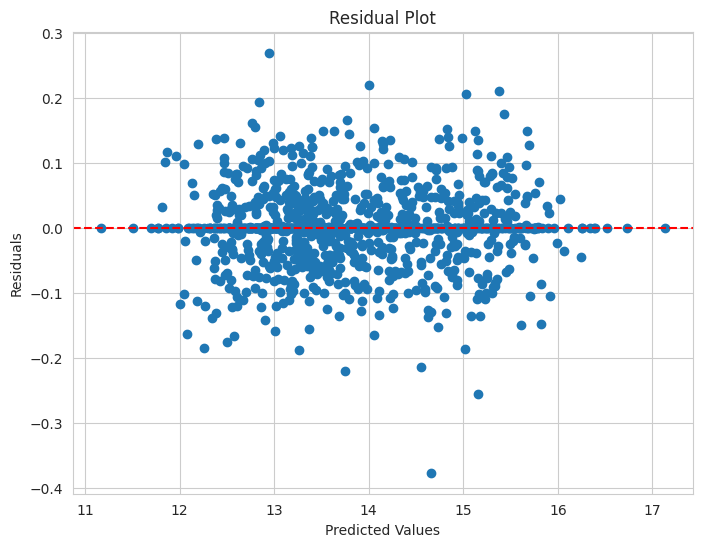

In [ ]:
# Calculate residuals
residuals = tf.squeeze(y).numpy() - tf.squeeze(y_hat).numpy()

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_hat, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('lr_scratch_resid.png')
plt.show()

#### Evaluate on Test Set

In [ ]:
from sklearn.exceptions import NotFittedError

In [ ]:
class Preprocessor:
    def __init__(self, X_train):
        self.X_train = X_train
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.imputer = KNNImputer(n_neighbors=1)
        self.max_age = self.X_train['Year'].max()


    def preprocess(self, X):
        # Create a copy of X to avoid modifying the original DataFrame

        X_processed = X.copy()
        num_cols = X.select_dtypes(include=np.number).columns
        cat_cols = X.select_dtypes(include=object).columns

        X_processed['LogPrice'] = np.log(X_processed['Price'])
        X_processed.drop(['Price'], inplace=True, axis=1)
        # Age Feature
        age = self.max_age - X_processed['Year']
        X_processed.insert(3, column='Age', value=age)
        X_processed.drop(['Year'], axis=1, inplace=True)

        # Car Volume Feature
        X_processed['Volume'] = X_processed['Length'] * X_processed['Height'] * X_processed['Width']

        # Max Power Feature
        max_bhp = X_processed['Max Power'].str.split(pat='@').str[0].str.split(pat=" ").str[0]
        max_rpm = X_processed['Max Power'].str.split(pat='@').str[1].str.split(pat=" ").str[1]
        vehicle_max_power_df = pd.DataFrame({'Max_Power_BHP': max_bhp, 'Max_Power_RPM': max_rpm})

        # Max Torque Feature
        max_bhp = X_processed['Max Torque'].str.split(pat='@').str[0].str.split(pat=" ").str[0]
        max_rpm = X_processed['Max Torque'].str.split(pat='@').str[1].str.split(pat=" ").str[1]
        vehicle_max_torque_df = pd.DataFrame({'Max_Torque_BHP': max_bhp, 'Max_Torque_RPM': max_rpm})

        # CC Feature
        cc = X_processed['Engine'].str.split(pat=" ").str[0]
        vehicle_cc_df = pd.DataFrame({'CC': cc})

        X_processed = pd.concat((X_processed, vehicle_max_power_df, vehicle_max_torque_df, vehicle_cc_df), axis=1)
        X_processed.drop(['Max Power', 'Max Torque', 'Engine'], axis=1, inplace=True)

        cat_cols = X_processed.select_dtypes(include=object).columns
        num_cols = X_processed.select_dtypes(include=np.number).columns

        # Convert specified columns to int64, handling potential errors
        for column in ['Max_Power_BHP', 'Max_Power_RPM', 'Max_Torque_BHP', 'Max_Torque_RPM', 'CC']:
          try:
            # Convert to numeric, coerce errors to NaN, fill NaN with 0, and then convert to Int64
            X_processed[column] = pd.to_numeric(X_processed[column], errors='coerce').fillna(0).astype(int)
          except KeyError:
            print(f"Column '{column}' not found in DataFrame.")


        # Scaling Numerical Values
        X_processed['Kilometer'] = X_processed['Kilometer'] / 10000
        X_processed['Length'] = X_processed['Length'] / 1000
        X_processed['Width'] = X_processed['Width'] / 1000
        X_processed['Height'] = X_processed['Height'] / 1000
        X_processed['Fuel Tank Capacity'] = X_processed['Fuel Tank Capacity'] / 10
        X_processed['Max_Power_BHP'] = X_processed['Max_Power_BHP'] / 100
        X_processed['Max_Power_RPM'] = X_processed['Max_Power_RPM'] / 1000
        X_processed['Max_Torque_BHP'] = X_processed['Max_Torque_BHP'] / 100
        X_processed['Max_Torque_RPM'] = X_processed['Max_Torque_RPM'] / 1000
        X_processed['CC'] = X_processed['CC'] / 1000

        # Encoding Categorical Attributes
        try:
          encoded_data = self.encoder.transform(X_processed[cat_cols])
        except NotFittedError:
          encoded_data = self.encoder.fit_transform(X_processed[cat_cols])
        cat_encoded_df = pd.DataFrame(encoded_data, columns=self.encoder.get_feature_names_out(cat_cols))
        X_processed_encoded_df = pd.concat([X_processed[num_cols].reset_index(drop=True), cat_encoded_df.reset_index(drop=True)], axis=1, ignore_index=True)

        num_cols_list = X_processed[num_cols].columns.to_list()
        cat_cols_list = cat_encoded_df.columns.to_list()
        all_columns = num_cols_list + cat_cols_list

        X_processed_encoded_df.columns = all_columns

        # Handling Missing Values
        X_processed_encoded_no_na = self.imputer.fit_transform(X_processed_encoded_df)
        X_processed_encoded_no_na_df = pd.DataFrame(X_processed_encoded_no_na, columns=all_columns)

        y = X_processed_encoded_no_na_df['LogPrice']
        X_processed_encoded_no_na_df.drop(['LogPrice'], axis=1, inplace=True)
        X = X_processed_encoded_no_na_df.to_numpy()
        intercept = np.ones((X.shape[0], 1))
        X = np.c_[X, intercept]

        return X, y

In [ ]:
X_train, X_test = train_test_split(
    filtered_df, test_size=0.3, stratify=filtered_df[['Make','Location']], random_state=42
)

In [ ]:
preprocessor = Preprocessor(X_train)

In [ ]:
X_np, y_np = preprocessor.preprocess(X_train)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)

# Fit the model to your training data
model.fit(X_np, y_np)



# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Evaluate the model (e.g., using R-squared or Mean Squared Error)
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

R-squared: 0.9965599352358127
Mean Squared Error: 0.0032061092861919486


In [ ]:
X_test_np, y_test_np = preprocessor.preprocess(X_test)

In [ ]:
y_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_pred)
mse = mean_squared_error(y_test_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

R-squared: 0.9416910569515647
Mean Squared Error: 0.05729888958501655


### Linear Regression with Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge


# Create a Ridge regression model
model =   # You can adjust the alpha parameter

# Fit the model to your training data
model.fit(X_np, y_np)

# You can now use the model to make predictions on new data
# y_pred = model.predict(X_new)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Evaluate the model (e.g., using R-squared or Mean Squared Error)
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

# Evaluate on the test set
X_test_np, y_test_np = preprocessor.preprocess(X_test)
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("Test R-squared:", r2)
print("Test Mean Squared Error:", mse)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


R-squared: 0.49415661332414895
Mean Squared Error: 0.4714414671095137
Test R-squared: 0.4530022510840831
Test Mean Squared Error: 0.5375224104534139


#### Hyperparameter Search - Grid Search

In [ ]:


from sklearn.model_selection import GridSearchCV

# Assuming X_np, y_np, X_test_np, and y_test_np are defined as in your original code

# Create a Ridge regression model
ridge = Ridge()

# Define the parameter grid for alpha
param_grid = {'alpha':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
# Create a GridSearchCV object

grid_search =

# Fit the grid search to your training data
grid_search.fit(X_np, y_np)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Get the best model
best_ridge_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = best_ridge_model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("Test R-squared (best model):", r2)
print("Test Mean Squared Error (best model):", mse)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254:

Best alpha: 0.26262626262626265
Test R-squared (best model): 0.4603828392078645
Test Mean Squared Error (best model): 0.5302696721620381


#### Hyperparameter Search - Random Search

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Assuming X_np, y_np, X_test_np, and y_test_np are defined as in your original code

# Create a Ridge regression model
ridge = Ridge()

# Define the parameter distribution for alpha
param_dist = {'alpha': }  # Alpha values between 0 and 1

# Create a RandomizedSearchCV object
random_search =
# Fit the random search to your training data
random_search.fit(X_np, y_np)

# Get the best alpha value
best_alpha = random_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Get the best model
best_ridge_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = best_ridge_model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("Test R-squared (best model):", r2)
print("Test Mean Squared Error (best model):", mse)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:254:

KeyboardInterrupt: 

In [ ]:
residuals = y_np - y_pred

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
residuals = y_test_np - y_test_pred

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Linear Regression with Lasso Regression

R-squared: 0.9547500030434771
Mean Squared Error: 0.04217258842123473
Test R-squared: 0.9154521033002931
Test Mean Squared Error: 0.0830833204028022


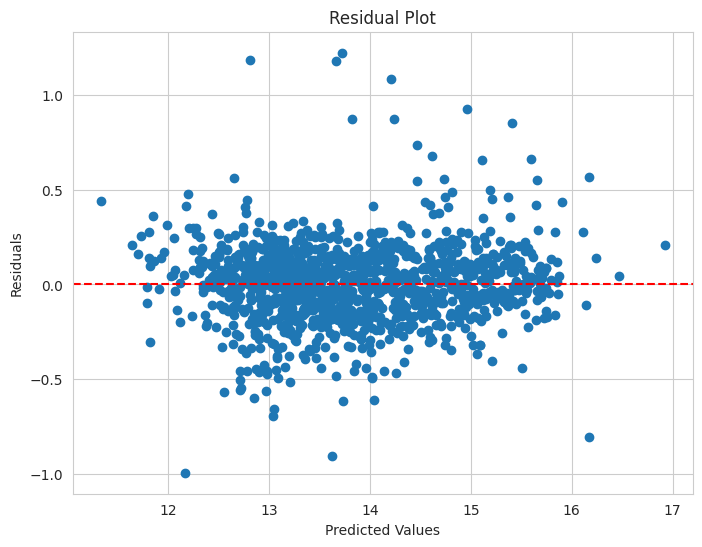

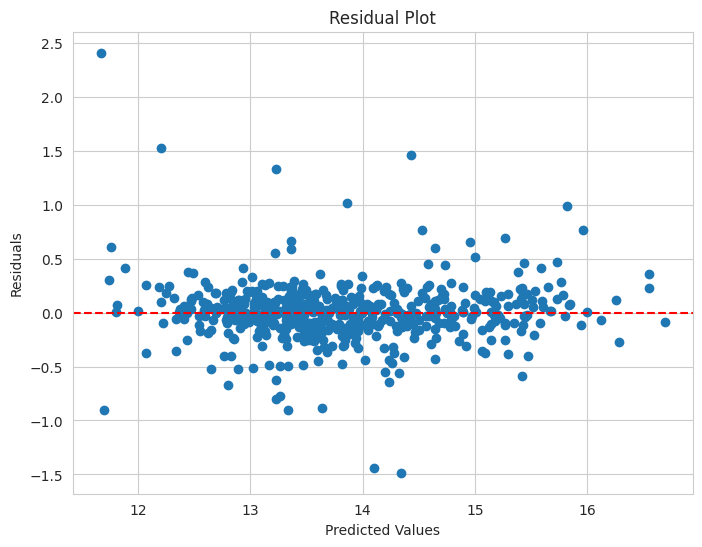

In [ ]:
from sklearn.linear_model import Lasso

#Create the model
model =

# Fit the model to your training data
model.fit(X_np, y_np)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Evaluate the model (e.g., using R-squared or Mean Squared Error)
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

# Evaluate on the test set
X_test_np, y_test_np = preprocessor.preprocess(X_test)
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("Test R-squared:", r2)
print("Test Mean Squared Error:", mse)

residuals = y_np - y_pred

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

residuals = y_test_np - y_test_pred

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#### Hyperparameter Search Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha
param_grid = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

# Create a Lasso regression model
lasso_model = Lasso()

# Create a GridSearchCV object
grid_search =

# Fit the GridSearchCV object to the training data
grid_search.fit(X_np, y_np)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("Test R-squared:", r2)
print("Test Mean Squared Error:", mse)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.235e+00, tolerance: 9.234e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.188e+00, tolerance: 9.145e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.480e+00, tolerance: 9.574e

Best alpha: 0.0001
Test R-squared: 0.9365186403080921
Test Mean Squared Error: 0.06238170732527056


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+01, tolerance: 1.175e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Assuming X_np, y_np, X_test_np, and y_test_np are defined as in your original code

# Create a Ridge regression model
lasso_model = Lasso()

# Define the parameter distribution for alpha
param_dist = {'alpha':  }

# Create a RandomizedSearchCV object
random_search =
# Fit the random search to your training data
random_search.fit(X_np, y_np)

# Get the best alpha value
best_alpha = random_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Get the best model
lasso_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = lasso_model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("Test R-squared (best model):", r2)
print("Test Mean Squared Error (best model):", mse)

Best alpha: 0.05522117123602399
Test R-squared (best model): 0.8132645286016007
Test Mean Squared Error (best model): 0.1835007564512874
